# What is Semantic Textual Similarity

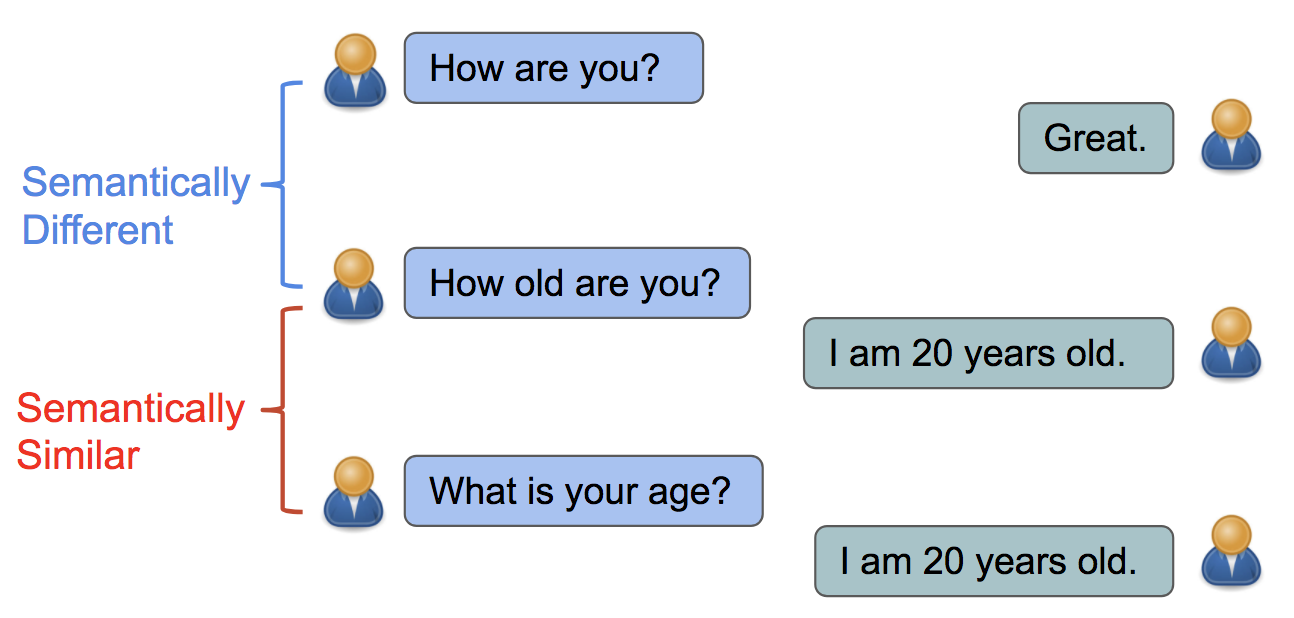

**Semantic Textual Similarity (STS)** refers to the task of quantifying the degree of semantic equivalence or similarity between pairs of texts. It involves measuring the similarity of meaning or understanding between two texts, regardless of their surface-level differences or syntactic structures.

The goal of STS is to develop computational models or algorithms that can assess the semantic similarity between texts, capturing the understanding of the underlying information rather than focusing on exact lexical or structural matches. STS is important in various natural language processing (NLP) applications, such as information retrieval, text summarization, question answering, machine translation, and plagiarism detection.

Approaches to Semantic Textual Similarity often involve the following steps:

1. **Preprocessing:**

- The texts are typically preprocessed by removing stop words, punctuation, and other noise that might not contribute significantly to the overall semantic similarity.

2. **Feature Extraction:**

- Features are extracted from the texts to capture their semantic content. These features can include word embeddings (such as Word2Vec or GloVe), contextualized embeddings (such as BERT or ELMO), or syntactic and semantic representations.

3. **Similarity Calculation:**

- Once the feature representations are obtained, a similarity metric or scoring function is applied to compute the similarity score between the pair of texts.
- Different similarity metrics can be used, such as cosine similarity, Euclidean distance, or a learned distance metric specific to the STS task.

4. **Training and Evaluation:**

- STS models are typically trained on pairs of texts with human-annotated similarity scores.
- The models are optimized to minimize the difference between predicted similarity scores and human-annotated similarity scores using techniques such as regression or ranking.
- Evaluation of STS models is often performed using standard evaluation datasets, such as the SemEval STS benchmarks, where the predicted similarity scores are compared against human judgments.
- The output of an STS system is a similarity score that quantifies the semantic similarity or relatedness between the given texts. The scores usually range from 0 to 1, with higher values indicating greater similarity.

**Let's deep dive to find the STS on Quora Question Pairs.**

# Table of Contents

* [Data Exploration](#section-one)
    
* [Text Preprocessing](#section-two)
    
* [Modelling - Sentence-BERT](#section-three)
    - [Sentence Embeddings using Siamese BERT-Networks](#subsection-one)
    - [What are Siamese Neural Networks?](#subsection-two)    
    - [Tokenizer](#subsection-three)
    - [Splitting the Data](#subsection-four)
    - [Adding a Distance Layer](#subsection-five)
    - [Build the model](#subsection-six)
    - [Optimize the Model](#subsection-seven)
    - [Train the model](#subsection-eight)
    - [Decoding some Teminologies](#subsection-nine)
    - [Fine-tuning the model](#subsection-ten)
    
* [Model Prediction & Evaluation](#section-four)
    
* [Conclusion](#section-five)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
nlp = spacy.load("en_core_web_sm")

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer,DataCollatorWithPadding,TFAutoModel,DistilBertConfig,TFDistilBertModel, BertConfig, TFBertModel, TFRobertaModel
from datasets import load_dataset

<a id="section-one"></a>
# Data Exploration

In [ ]:
df = pd.read_csv("../input/quora-question-pairs/train.csv.zip")
df_test = pd.read_csv("../input/quora-question-pairs/test.csv.zip", low_memory=False)
df_sub = pd.read_csv("../input/quora-question-pairs/sample_submission.csv.zip")

In [ ]:
# Checking unique IDs
len(df['id'].unique()), len(df['qid1'].unique()), len(df['qid2'].unique())

In [ ]:
# Do ID repeats? If yes, how often?
display(df['qid1'].value_counts(ascending=False))
print("\n")
display(df['qid2'].value_counts(ascending=False))

## Checking Nulls

In [ ]:
# Are there any nulls?
df.isnull().sum()

In [ ]:
# Which are the IDs?
nan_qid1 = set(df[df['question1'].isnull()]['qid1'])
nan_qid2 = set(df[df['question2'].isnull()]['qid2'])

nan_ids = nan_qid1.union(nan_qid2)
print(f"These 2 IDs {nan_ids} are NULL. Let's drop them!")

In [ ]:
# dropping the nulls
df.dropna(inplace=True)

## Target Distribution

In [ ]:
df['is_duplicate'].hist()

<a id="section-two"></a>
# Text Preprocessing

We will do Text Preprocessing in Python using spaCy library in detail. This is the fundamental step to prepare data -

Some of the text preprocessing techniques we have covered are:

- Tokenization
- Lemmatization
- Removing Punctuations and Stopwords

In [ ]:
def clean_text(x):
    
    text = re.sub('\s+\n+', ' ', x)
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    text = text.lower()
    
    return text

df['question1_cleaned'] = df['question1'].apply(lambda x : clean_text(x))
df['question2_cleaned'] = df['question2'].apply(lambda x : clean_text(x))
df

## How Sentence Length Distributions looks like?

- In order to get the accurate length of the sentence, we will see how the Sentence Length Distributions looks like, then will choose the appropriate length that should be used in our model
- Easy way is to take the maximum sentence length, but it may increase the dimensions if there are any outliers present in our data. Hence, a more informed decision can be made which will help in reducing the parameters of our model.They can be padded with transformers based models, as they usually mask out the sentences which are short but are padded to a longer length, but since we are focused on finding the ideal length statistically we will go ahead with that

In [ ]:
df['question1_length'] = df['question1_cleaned'].apply(lambda x : len(x.split()))
df['question2_length'] = df['question2_cleaned'].apply(lambda x : len(x.split()))

In [ ]:
df[['question1_length', 'question2_length']].describe()

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(df, x="question1_length", fill=True, ax=axs[0])
sns.kdeplot(df, x="question2_length", fill=True, ax=axs[1])
f.tight_layout()

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.scatterplot(data=df, x="id", y="question1_length", ax=axs[0])
sns.scatterplot(data=df, x="id", y="question2_length", ax=axs[1])
f.tight_layout()

## How to detect outliers: 

We can find outliers using data visualization/graphical methods and statistical methods. 

In graphical methods we could use scatter plot and box plot. In statistical methods we can use percentile capping, IQR (inter quantile range) and standard deviation.

1. **Graphical methods**

- **Scatter plot:-** We draw the scatter plot and any data points far away from the population can be considered as outliers. Data points in red can be consider as outliers.
  
- **Box plot:** - When reviewing a Boxplot, an outlier is defined as a data point that is located outside the fences (“whiskers”) of the boxplot (e.g. outside 1.5 times the interquartile range above the upper quartile and bellow the lower quartile). In the below figure data points above inner fence are possible outliers.

2. **Statistical methods**
- **Percentile capping:** - Any data points less than the value at first percentile or greater than value at 99th percentile could be possible outliers.

- **IQR (inter quantile range):**- If a value is higher than the 1.5*IQR above the upper quartile (Q3), the value will be considered as outlier. Similarly, if a value is lower than the 1.5*IQR below the lower quartile (Q1), the value will be considered as outlier.
      IQR = Q3 -Q1
      Lower limit of acceptable range = Q1 - 1.5* (Q3-Q1)
      Upper limit of acceptable range = Q3 + 1.5* (Q3-Q1) 

3. **Standard Deviation Method:** - If a value is higher or lower by three Standard Deviation from mean is considered as outlier. It is based on the characteristics of a normal distribution for which 99.87% of the data appear within this range. 

**Inference:** - In this notebook, we are going to use IQR method as our distribution is not normal, hence its better to cap the outliers using IQR.

In [ ]:
Q1 = df['question1_length'].quantile(0.25)
Q3 = df['question1_length'].quantile(0.75)
IQR = Q3-Q1
standard_outlier = Q3 + 1.5*IQR
extreme_outlier = Q3 + 3*IQR

print(f"Lower Q is {Q1} and upper is {Q1}. Hence, IQR is {IQR} \n Standard Out {standard_outlier} \n Extreme Out {extreme_outlier}")

**Inference:** Upper outlier is 22, and extreme 31. Lets take 50 to be the ideal length so that some of the extremely long sentences can also be represented well enough for our model.

<a id="section-three"></a>
# Modelling

<a id="subsection-one"></a>
## Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks

BERT has set a new state-of-the-art performance on sentence-pair regression tasks like semantic textual similarity (STS). However, it requires that both sentences are fed into the network, which causes a massive computational overhead: Finding the most similar pair in a collection of 10,000 sentences requires about 50 million inference computations (~65 hours) with BERT. The construction of BERT makes it unsuitable for semantic similarity
search as well as for unsupervised tasks like clustering. 

In this notebook, we will be using Sentence-BERT (SBERT), a modification of the pretrained BERT network that use **siamese** and **triplet** network structures to derive semantically meaningful sentence embeddings that can be compared using cosine-similarity. This reduces the effort for finding the most similar pair from 65 hours with BERT / RoBERTa to about 5 seconds with SBERT, while maintaining the accuracy from BERT. Refer [here](https://arxiv.org/abs/1908.10084)


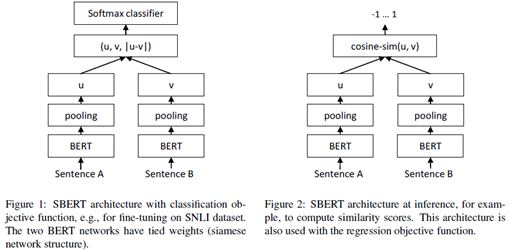

The most important component is the elementwise difference |u – v|. Note, that the concatenation mode is only relevant for training the softmax classifier. At inference, when predicting similarities for the STS benchmark dataset, only the sentence embeddings u and v are used in combination with cosine-similarity. The element-wise difference measures the distance between the dimensions of the two sentence embeddings, ensuring that similar pairs are closer and dissimilar pairs are further apart.

To overcome this shortcoming, we presented Sentence-BERT (SBERT). SBERT fine-tunes BERT in a siamese / triplet network architecture. And its been evalued in the paper that the quality on various common benchmarks, where it could achieve a significant improvement over state-of-the-art sentence embeddings methods.


<a id="subsection-two"></a>
## What are Siamese Neural Networks?

Siamese neural networks are a type of neural network architecture designed for learning similarity or dissimilarity between pairs of inputs. They are named after the mythological concept of Siamese twins, as the network architecture consists of two identical subnetworks that share weights and are joined at the end.

The key idea behind Siamese neural networks is to learn a feature representation that captures the similarity or dissimilarity between pairs of inputs. This makes them particularly useful in tasks such as similarity matching, image or text retrieval, signature verification, face recognition, and more.

Here's a basic overview of how Siamese neural networks work:

1. **Architecture:**

- A Siamese network consists of two identical subnetworks, often implemented using convolutional or feed-forward layers.
- The two subnetworks have shared weights, meaning that they learn the same set of parameters.
- Each subnetwork takes one input from a pair of inputs and processes it independently to extract meaningful feature representations.

2. **Feature Extraction:**

- The subnetworks extract high-level feature representations from their respective inputs.
- These feature representations capture the essential characteristics of the inputs that are relevant to the similarity or dissimilarity metric being learned.

3. **Joining and Comparison:**

- The feature representations from both subnetworks are combined, often using a distance metric or similarity measure such as Euclidean distance or cosine similarity.
- The comparison is typically performed in a subsequent layer or as a separate post-processing step.

4. **Training:**

- Siamese networks are trained using pairs of inputs along with their corresponding similarity or dissimilarity labels.
- During training, the network learns to optimize the feature representations so that they are more discriminative for similar pairs and less discriminative for dissimilar pairs.
- The training process involves minimizing a loss function, such as contrastive loss or triplet loss, that encourages similar pairs to have low distances or high similarities and dissimilar pairs to have high distances or low similarities.

By training Siamese neural networks on labeled pairs of inputs, they can learn to effectively measure similarity or dissimilarity between different types of data. They are particularly useful when labeled data for specific classes or categories is limited, as they can leverage similarity information rather than relying solely on explicit class labels.

Overall, Siamese neural networks provide a powerful framework for learning similarity or dissimilarity between pairs of inputs and have demonstrated success in various applications requiring similarity-based comparisons.

<a id="subsection-three"></a>
## Tokenizer

In [ ]:
model_checkpoint = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer

In [ ]:
def text_encoding(text):
    
    encode_out = tokenizer.batch_encode_plus(text,
                                    add_special_tokens=True,
                                    max_length=60,
                                    padding=True,
                                    truncation=True,
                                    return_attention_mask=True,
                                    return_tensors="tf")
    
    input_ids = np.array(encode_out.get('input_ids'), dtype="int32") # converts list to an array
    attention_masks = np.array(encode_out.get('attention_mask'), dtype="int32") # converts list to an array
    segment_ids = np.array(encode_out.get('token_type_ids'), dtype="int32") # converts list to an array
    
    return {
         "input_ids": input_ids,
         "attention_masks": attention_masks,
#          "segment_ids": segment_ids 
    }    

**Note:** The tokenizer.tokenize method returns a dictionary containing the following items:

- **input_ids:** This is a list of tokenized and encoded sequences, represented as integer IDs. Each ID corresponds to a specific token in the vocabulary of the tokenizer.

- **attention_mask:** This is a list of attention masks that indicate which tokens are valid words and which ones are padding tokens. It has the same shape as the input_ids list.

- **token_type_ids:** This is an optional item that represents the segment or sentence IDs in case of models that expect input from multiple sequences, such as BERT. It is not always present in the returned dictionary.

<a id="subsection-four"></a>
## Splitting the Data

In [ ]:
data = df.sample(400000, random_state=42)

# TRAIN:VALID :: 80:15
N = len(data) 
TRAIN_idx = int(np.floor(N*0.8)) 

train = data.iloc[:TRAIN_idx, :]
val = data.iloc[TRAIN_idx:, :]

train.shape, val.shape

In [ ]:
X1_train = text_encoding(train['question1_cleaned'].tolist())
X2_train = text_encoding(train['question2_cleaned'].tolist())

X1_val = text_encoding(val['question1_cleaned'].tolist())

X2_val = text_encoding(val['question2_cleaned'].tolist())

In [ ]:
# X
X_train = (np.asarray(X1_train['input_ids']),np.asarray(X1_train['attention_masks']),
           np.asarray(X2_train['input_ids']),np.asarray(X2_train['attention_masks']))

X_val = (np.asarray(X1_val['input_ids']),np.asarray(X1_val['attention_masks']),
           np.asarray(X2_val['input_ids']),np.asarray(X2_val['attention_masks']))

# y
y_train = train['is_duplicate'].values
y_val = val['is_duplicate'].values

<a id="subsection-five"></a>
## Adding a Distance Layer

In [ ]:
class L1Dist(Layer):
    
    def __init__(self,**kwargs):
        super().__init__()
        
    def call(self,sequence_avg_output1,sequence_avg_output2):
        return tf.math.abs(sequence_avg_output1 - sequence_avg_output2)

<a id="subsection-six"></a>
## Build the model

In [ ]:
# Create the model under a distribution strategy scope.
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    
    # Encoded token ids from BERT tokenizer.
    # Input() is used to instantiate a Keras tensor.
    
    # Input-1
    input_ids1 = Input(
        shape=(None,), dtype=tf.int32, name="input_ids1"
    )
    # Attention masks indicates to the model which tokens should be attended to.
    attention_masks1 = Input(
        shape=(None,), dtype=tf.int32, name="attention_masks1"
    )
    
    # Input-2
    input_ids2 = Input(
        shape=(None,), dtype=tf.int32, name="input_ids2"
    )
    # Attention masks indicates to the model which tokens should be attended to.
    attention_masks2 = Input(
        shape=(None,), dtype=tf.int32, name="attention_masks2"
    )
    
    # Loading pretrained BERT model.
    bert_model = TFBertModel.from_pretrained(model_checkpoint)
    
    # Freeze the BERT model to reuse the pretrained features without modifying them.
    bert_model.trainable = False

    # Embeddings for input1
    bert_output1 = bert_model(
        input_ids1, attention_mask=attention_masks1)
    # Embeddings for input2
    bert_output2 = bert_model(
        input_ids2, attention_mask=attention_masks2)
    
    sequence_output1 = bert_output1.last_hidden_state
    sequence_output2 = bert_output2.last_hidden_state
    
    # Applying GlobalAveragePooling approach to bert sequence output.
    sequence_avg_output1 = GlobalAveragePooling1D()(sequence_output1)
    sequence_avg_output2 = GlobalAveragePooling1D()(sequence_output2)
    
    distance_output = L1Dist()(sequence_avg_output1, sequence_avg_output1)
    
    dense_l1 = Dense(512, activation='relu')(distance_output)
    output = Dense(1, activation="sigmoid")(dense_l1)
    
    model = Model(
        inputs=[input_ids1, attention_masks1, input_ids2, attention_masks2], outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
        loss="binary_crossentropy",
        metrics=["acc"],
    )

In [ ]:
print(f"Strategy: {strategy}")
model.summary()

<a id="subsection-seven"></a>
## Optimize the Model Performance by **'EarlyStopping'** and **'ReduceLROnPlateau'**

**'EarlyStopping'** and **'ReduceLROnPlateau'** are techniques used in training neural networks to improve the model's performance and prevent overfitting. They are typically implemented as callbacks during the training process.

**EarlyStopping:**

1. EarlyStopping is a technique used to monitor the training progress and stop the training process early if the model's performance on a validation set stops improving.
2. It helps prevent overfitting by terminating the training process before the model starts to memorize the training data and instead captures more generalizable patterns.
3. EarlyStopping requires defining a performance metric to monitor, such as validation loss or accuracy.
4. The technique works by monitoring the performance metric over a certain number of epochs (patience) and stopping the training if the metric does not improve for a specified number of epochs.
5. Once training is stopped, the model can be saved based on the best observed performance during training.

**ReduceLROnPlateau:**

1. ReduceLROnPlateau is a technique used to adjust the learning rate during training when the model's performance on a validation set plateaus.
2. It aims to fine-tune the learning process and help the model converge to a better solution.
3. ReduceLROnPlateau monitors a specified metric, such as validation loss or accuracy, and reduces the learning rate if the monitored metric does not improve for a certain number of epochs (patience).
4. By reducing the learning rate, the technique allows the model to take smaller steps during optimization, which can help escape local minima and find a better solution.
5. Reducing the learning rate can be done by a certain factor (e.g., dividing it by 2) or by a fixed amount.
6. The technique can be helpful when the learning rate is initially set too high and the model is unable to converge or when the model gets stuck in a suboptimal solution.

Both EarlyStopping and ReduceLROnPlateau are useful techniques for training neural networks effectively, preventing overfitting, and optimizing the model's performance by stopping the training early or adjusting the learning rate when necessary.

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.3, 
                                            min_lr=0.00000001)

<a id="subsection-eight"></a>
## Train the Model
Training is done only for the top layers to perform "feature extraction", which will allow the model to use the representations of the pretrained model.

#### **Note: I have restricted to 3 EPOCHS due to time constraint, but feel free to increase this number for better results**

In [ ]:
BATCH_SIZE = 32
EPOCHS = 3 #5

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[earlystopping, 
               learning_rate_reduction]
#     use_multiprocessing=True,
#     workers=-1,
)

<a id="subsection-nine"></a>
## Decoding some Teminologies

### What does **bert_model.trainable** = False/True mean?

1. The line of code **bert_model.trainable** = False is used to set the trainable attribute of a BERT model to False. This line of code suggests that the BERT model's parameters should not be updated or fine-tuned during the training process.

2. In machine learning models, the trainable attribute determines whether the parameters (weights) of a model should be adjusted during training or remain fixed. When the trainable attribute is set to True, the model's parameters are updated based on the gradients computed during backpropagation, allowing the model to learn from the training data. On the other hand, when it is set to False, the model's parameters are frozen, and their values remain unchanged during training.

3. Setting bert_model.trainable = False is useful in scenarios where you want to use a pre-trained BERT model as a fixed feature extractor or when you have limited training data and want to avoid overfitting. By freezing the BERT model's parameters, you can leverage the pre-trained knowledge of BERT and focus on training only the additional layers or components added on top of BERT.

4. After setting trainable to False, you can continue training the rest of the model (if any) while keeping the BERT layers fixed. This can be done by selectively setting the trainable attribute for different parts of your model.

### What does **bert_model.last_hidden_state** represents?

1. **bert_output.last_hidden_state** refers to the last hidden state of the BERT model output. In BERT (Bidirectional Encoder Representations from Transformers), the model takes in a sequence of tokens as input and processes them through a series of Transformer layers to obtain contextualized representations of each token.

2. The last_hidden_state represents the final hidden state of each token in the input sequence after it has been processed by the BERT model. It is a tensor that has the shape [batch_size, sequence_length, hidden_size], where:

- batch_size refers to the number of input sequences in a batch.
- sequence_length refers to the maximum length of the input sequences in the batch.
- hidden_size refers to the dimensionality of the hidden state representation.
- Each element in the last_hidden_state tensor represents the contextualized representation of a token in the input sequence. The contextualized representation takes into account the surrounding context and captures the meaning and relationships between the tokens.

3. The last_hidden_state is often used as input to downstream tasks or additional layers added on top of the BERT model. It can be further processed or fed into other models for tasks such as text classification, named entity recognition, question answering, and more.

**Note** that the BERT model output may include additional information such as pooled representations (bert_output.pooler_output) or attention weights, but bert_output.last_hidden_state specifically refers to the final hidden state representations of the tokens in the input sequence.

## Whats the difference between **AveragePooling** layers and **GlobalAveragePooling** layers 

AveragePooling layers and GlobalAveragePooling layers are both common operations used in convolutional neural networks (CNNs) for dimensionality reduction and feature extraction. However, they differ in terms of the scope of the pooling operation.

**AveragePooling Layer:**

- AveragePooling layers divide the input feature map into non-overlapping regions (typically squares) and replace each region with the average value of that region.
- These layers reduce the spatial dimensions of the input, resulting in a smaller feature map.
- The pooling operation is applied locally within each region and independently across different channels.
- AveragePooling layers are typically used to downsample the feature maps, reducing computational complexity and capturing the most salient features in a coarser representation.
- The size of the pooling regions and the stride (the step size for moving the pooling window) are usually specified in the layer configuration.

**GlobalAveragePooling Layer:**

- GlobalAveragePooling layers perform pooling operations over the entire spatial dimensions of the input feature map, collapsing each feature map into a single value per channel.
- Unlike AveragePooling, there is no region or window involved. Instead, it computes the average of all the spatial locations for each channel independently.
- GlobalAveragePooling layers reduce both the spatial dimensions and the number of channels, resulting in a one-dimensional output.
- This operation is often applied to the final feature maps of a CNN, aggregating the spatial information into a global representation.
- GlobalAveragePooling layers are commonly used as a replacement for fully connected layers at the end of a CNN, providing a compact and informative feature vector for classification or regression tasks.

In summary, while AveragePooling layers perform pooling operations within local regions of the input, GlobalAveragePooling layers compute the average across the entire spatial dimensions of the input, resulting in a global representation.

<a id="subsection-ten"></a>
## Fine-tuning

This is an optional last step where bert_model is unfreezed and retrained with a very low learning rate. This can deliver meaningful improvement by incrementally adapting the pretrained features to the new data.

In my case, due to resource constraint, I am not fine-tuning it, but if someone wishes to, follow the below lines of code.

In [ ]:
# Unfreeze the bert_model.

# bert_model.trainable = True
# # Recompile the model to make the change effective.
# model.compile(
#     optimizer=Adam(1e-5),
#     loss="binary_crossentropy",
#     metrics=["accuracy"],
# )

# model.summary()

## Train the entire model end-to-end

In [ ]:
# history = model.fit(
#     train_data,
#     validation_data=valid_data,
#     epochs=epochs,
#     use_multiprocessing=True,
#     workers=-1,
# )

<a id="section-four"></a>
## Model Prediction & Evaluation

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<a id="section-five"></a>
## Conclusion

- Model loss is falling at each epoch, while our training and validation loss is not improving much. **Note: I have restricted to 3 EPOCHS due to time constraint, but feel free to increase this number for better results**

- Our model achieves an F1-score of 77%. It can be further improved by improving text processing and running more EPOCHS.

### If you find this notebook useful👋, please .**Upvote.**👍🤞